# NYC Taxi

## Introduction

A new ride sharing company is your client. They are looking to start up a rival service to Uber or Lyft in NYC and are interested in using the Taxi Data to get insight into the transportation sector in New York. They have tasked you to get to know the data and start to build some simple models off of it.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### Config

In [2]:
DATA_PATH = 'data/'

### Data Loading

In [3]:
dfs = []
for file in os.listdir(DATA_PATH):
    print(f'Loading file {file}')
    dfs.append(pd.read_parquet(os.path.join(DATA_PATH, file), engine='fastparquet'))
data = pd.concat(dfs)
print(f'Final dataset shape {data.shape}')

Loading file yellow_tripdata_2017-03.parquet
Loading file yellow_tripdata_2017-11.parquet
Loading file yellow_tripdata_2017-06.parquet
Final dataset shape (29237237, 19)


## Exploratory Data Analysis & Data Summary

To start, I will print few examples of data rows.

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2017-03-01 00:38:16,2017-03-01 00:59:21,1,10.5,1,N,231,42,1,30.5,0.5,0.5,6.00,0.0,0.3,37.80,<NA>,<NA>
1,1,2017-03-01 00:25:01,2017-03-01 00:31:36,1,1.4,1,N,239,262,1,7.5,0.5,0.5,1.75,0.0,0.3,10.55,<NA>,<NA>
2,1,2017-03-01 00:43:48,2017-03-01 00:44:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,<NA>,<NA>
3,1,2017-03-01 00:47:17,2017-03-01 00:47:33,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,<NA>,<NA>
4,1,2017-03-01 00:13:37,2017-03-01 00:13:46,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,<NA>,<NA>


In the first few rows we can see some interesting things. First, we have some different types of data. Some seem to be categorical, some are dates and also we can see there are two columns, *congestion_surcharge* and *airport_fee* that contains *NA* values. Let's see description of the different columns.

In [5]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29237237 entries, 0 to 9656992
Data columns (total 19 columns):
 #   Column                 Non-Null Count     Dtype         
---  ------                 --------------     -----         
 0   VendorID               29237237 non-null  int64         
 1   tpep_pickup_datetime   29237237 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  29237237 non-null  datetime64[ns]
 3   passenger_count        29237237 non-null  int64         
 4   trip_distance          29237237 non-null  float64       
 5   RatecodeID             29237237 non-null  int64         
 6   store_and_fwd_flag     29237237 non-null  object        
 7   PULocationID           29237237 non-null  int64         
 8   DOLocationID           29237237 non-null  int64         
 9   payment_type           29237237 non-null  int64         
 10  fare_amount            29237237 non-null  float64       
 11  extra                  29237237 non-null  float64       
 12  mta_tax      

With this description of the dataset we can see that the two columns containing *NA* values are completely empty. Also, we see that none of the remaining columns contain missing values, which is really good and something strange in real world datasets. 

Also, there are some columns that are represented as integers but could be better represented as Categorical data type. These columns are:

- PULocationID
- DOLocationID
- VendorID
- store_and_fwd_flag
- RatecodeID
- payment_type

So I will convert them to Categorical. This will also help to reduce the dataset size (in terms of memory usage), which will make it easier to work with.

In [6]:
cat_columns = ['PULocationID', 'DOLocationID', 'VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type']
for col in cat_columns:
    data[col] = pd.Categorical(data[col])

Drop empty columns.

In [7]:
data.drop(columns=['congestion_surcharge', 'airport_fee'], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29237237 entries, 0 to 9656992
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
dtypes: category(6), datetime64[ns](2), float64(8), int64(1)
memory u

As we can see in the info above, we fixed the different columns and this reduced the memory usage of the dataset in a ~33%.

Next, I will explore the distribution of the variables. For this, I will split the data into different sets depending in their type: Numerical, Categorical and Dates.

In [9]:
num_features = data.select_dtypes(['int', 'float'])

In [10]:
cat_features = data.select_dtypes('category')

In [11]:
date_features = data.select_dtypes('datetime')

### Numeric features

Let's start with the numeric features. First, I will describe them through basic statistical measures and also I will plot their distributions

In [12]:
num_features.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07,2.923724e+07
mean,1.617837e+00,2.919382e+00,1.310928e+01,3.339417e-01,4.973105e-01,1.874053e+00,3.290105e-01,2.996283e-01,1.644708e+01
std,1.261040e+00,4.476505e+00,1.472796e+02,4.615720e-01,7.081616e-02,2.645560e+00,1.968867e+00,1.408884e-02,1.475227e+02
min,0.000000e+00,0.000000e+00,-5.500000e+02,-5.371000e+01,-5.000000e-01,-1.120000e+02,-1.750000e+01,-3.000000e-01,-5.503000e+02
25%,1.000000e+00,9.700000e-01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.750000e+00
50%,1.000000e+00,1.600000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.180000e+01
75%,2.000000e+00,3.010000e+00,1.450000e+01,5.000000e-01,5.000000e-01,2.460000e+00,0.000000e+00,3.000000e-01,1.780000e+01
max,1.920000e+02,9.496980e+03,6.304618e+05,6.980000e+01,1.400000e+02,4.500000e+02,1.018950e+03,1.000000e+00,6.304631e+05


array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'fare_amount'}>],
       [<AxesSubplot:title={'center':'extra'}>,
        <AxesSubplot:title={'center':'mta_tax'}>,
        <AxesSubplot:title={'center':'tip_amount'}>],
       [<AxesSubplot:title={'center':'tolls_amount'}>,
        <AxesSubplot:title={'center':'improvement_surcharge'}>,
        <AxesSubplot:title={'center':'total_amount'}>]], dtype=object)

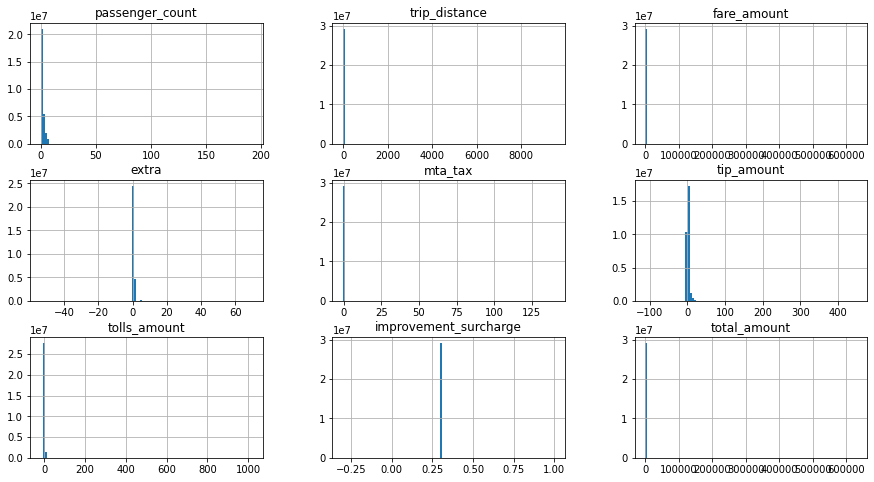

In [13]:
num_features.hist(bins=100, figsize=(15, 8))

By looking at the statistical descriptors and the distribution plots we can see many interesting things. I will list them in the following lines.

- **passenger_count**: 
    - I can see the minimum number of passenger is 0. Does makes sense a ride without passengers?? Here I will take **the assumption that this is wrong**, so these values will be deleted.
    - The maximum number of passengers is 192. This is clearly a mistake, so this value will also be deleted.
    - Finally, if we take a look at the Value Counts, we see that we also have some big number of passengers. After a quick research on the internet, **I will assume that there are big taxis that can take up to 6 passengers**, all the others are errors and will also be deleted.

In [14]:
data['passenger_count'].value_counts()

1      20962609
2       4219587
5       1388266
3       1205107
6        850939
4        558726
0         51760
8            88
7            88
9            66
192           1
Name: passenger_count, dtype: int64

In [15]:
data_clean = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]

Around 52k records have been deleted.

- **trip_distance**
    - Minimum trip distance is 0 miles. These recors will be deleted.
    - Maximum trip distance is 9496.98 miles, which seems to be an error. 
    - In the case of Trip distance, since it's a float variable and it's harder to decide when it's outlier and when it's not, a quantitative method will be used to decide: the IQR method. But first I will delete the values having 0 miles.

In [16]:
data_clean = data_clean[data_clean['trip_distance'] > 0]

In [17]:
data_clean['trip_distance'].describe()

count    2.899567e+07
mean     2.938921e+00
std      4.486187e+00
min      1.000000e-02
25%      9.900000e-01
50%      1.620000e+00
75%      3.040000e+00
max      9.496980e+03
Name: trip_distance, dtype: float64

I will define a functions that will delete the outliers of a given column by using the IQR method.

In [18]:
def delete_outliers(df, feature):
    """
    Delete outliers for the given feature using the IQR Method
    """
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    
    lower_limit = q1 - 3 * iqr
    upper_limit = q3 + 3 * iqr
    
    return df[(df[feature] >= lower_limit) & (df[feature] <= upper_limit)]

In [19]:
data_clean = delete_outliers(data_clean, 'trip_distance')

- **fare_amount**
    - I found negative fare amounts. This might be corrections on some amounts or something like that but since it doesn't makes sense for us, we will keep only **positive** fare amounts.
    - The maximum amount is 630k$, which doesn't makes sense as well. 
    - I will delete outliers using the IQR method too.

In [20]:
data_clean = data_clean[data_clean['fare_amount'] > 0]

In [21]:
data_clean = delete_outliers(data_clean, 'fare_amount')

- **extra**
    - This variable description in the Dictionary is a bit ambiguous. I'm not sure if it only includes 0.5 and 1.0 charges for *Rush hour* and *Overnight Charges*, or 0.5, 1 and *Overnight Charges*. In my case, **I will just assume that we have only positive values and I will detect outliers based in the IQR method** as done with previous variables. 

In [22]:
data_clean = data_clean[data_clean['extra'] >= 0]

In [23]:
data_clean = delete_outliers(data_clean, 'extra')

- **mta_tax**
    - In this variable something similar happens. The dictionary says it includes only 0.5\\$ tax, but I can find many different values. To continue witht he same approach, **I will take only positive values and remoe outliers based on the IQR method**.
    - Still, after applying the IQR method, the resulting values are only these showing 0.5.

In [24]:
data_clean = data_clean[data_clean['mta_tax'] >= 0]

In [25]:
data_clean = delete_outliers(data_clean, 'mta_tax')

- **tip_amount**
    - In tip amount we also find negative values. We will keep only the positive ones (and zero).
    - The outliers will be deleted using the IQR method.

In [26]:
data_clean = data_clean[data_clean['tip_amount'] >= 0]

In [27]:
data_clean = delete_outliers(data_clean, 'tip_amount')

- **tolls_amount**
    - Same process as in the other numeric features. We keep only positive (and zero) values
    - Remove outliers using IQR method

In [28]:
data_clean = data_clean[data_clean['tolls_amount'] >= 0]

In [29]:
data_clean = delete_outliers(data_clean, 'tolls_amount')

- **improvement_surcharge**
    - Same process as in the other numeric features. We keep only positive (and zero) values
    - Remove outliers using IQR method

In [30]:
data_clean = data_clean[data_clean['improvement_surcharge'] >= 0]

In [31]:
data_clean = delete_outliers(data_clean, 'improvement_surcharge')

- **total_amount**
    - Since this value includes the tip amount, we can't use it to predict the tip amount itself in our model, so it should be removed.

In [32]:
data_clean = data_clean.drop(columns=['total_amount'])

Now let's plot the distributions of the variables once again with the clean data.

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'trip_distance'}>,
        <AxesSubplot:title={'center':'fare_amount'}>],
       [<AxesSubplot:title={'center':'extra'}>,
        <AxesSubplot:title={'center':'mta_tax'}>,
        <AxesSubplot:title={'center':'tip_amount'}>],
       [<AxesSubplot:title={'center':'tolls_amount'}>,
        <AxesSubplot:title={'center':'improvement_surcharge'}>,
        <AxesSubplot:>]], dtype=object)

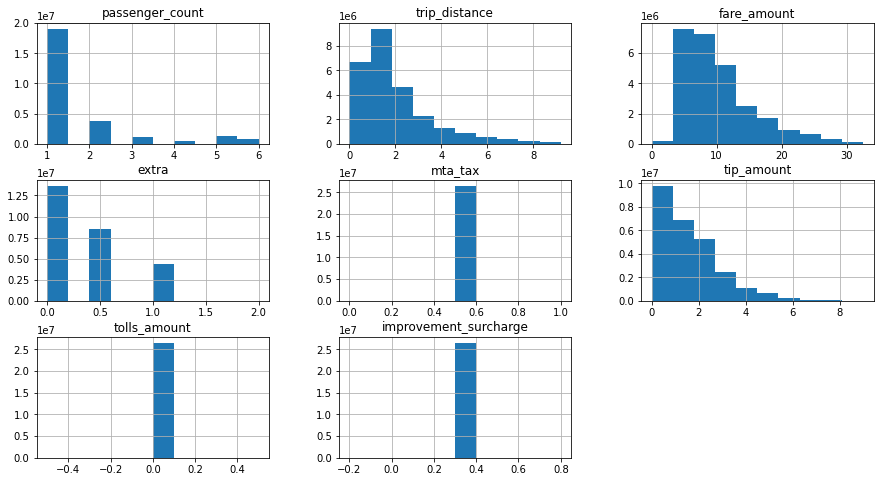

In [33]:
data_clean.hist(figsize=(15, 8))

### Categorical features

- Eliminar los payment_type 3, ya que son manuales y no incluyen las propinas
- Codificar Store_and_fwd como 0/1
- VendorID como one_hot??
- onehot para RatecodeID??

In [34]:
cat_features.head()

,VendorID,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type
0,1,1,N,231,42,1
1,1,1,N,239,262,1
2,1,1,N,145,145,2
3,1,1,N,145,145,2
4,1,1,N,145,145,2


In [35]:
cat_features.describe()

,VendorID,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type
count,29237237,29237237,29237237,29237237,29237237,29237237
unique,2,7,2,262,263,5
top,2,1,N,237,236,1
freq,15961088,28408219,29112771,1159345,1090547,19845082


We have several category columns here. Let's describe each one of them.

- **VendorID**
    - It describes provider of the record. Seem to be balanced, since almost half of the records are for each provider

<AxesSubplot:title={'center':'VendorID'}>

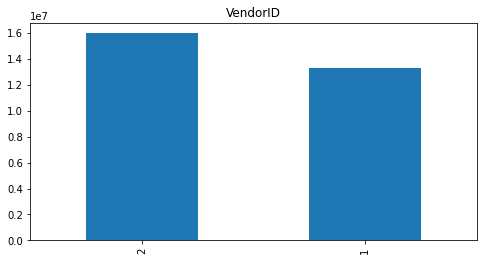

In [36]:
cat_features['VendorID'].value_counts().plot(kind='bar', title='VendorID', figsize=(8, 4))

- **RatecodeID**
    - It is very unbalanced. I think it also does not give important information as that information is already implicitly given by the amount of the fee. Still, I will keep this variable to study more about it.
    

<AxesSubplot:>

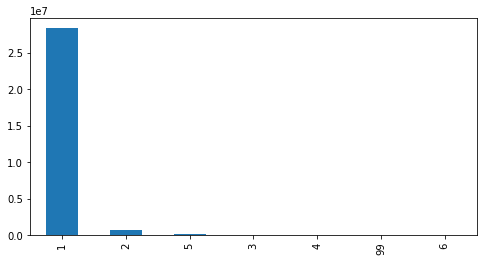

In [37]:
cat_features['RatecodeID'].value_counts().plot(kind='bar', figsize=(8, 4))

- **store_and_fwd_flag**
    - This binary column tell us if the record was held in vehicle memory or not because it didn't have connection to the server. I don't think it will be relevant to the analysis but by the moment we will keep it to see if there is any correlation between it and the tip amount.
    - Can be converted to 0/1 to represent true/false

<AxesSubplot:>

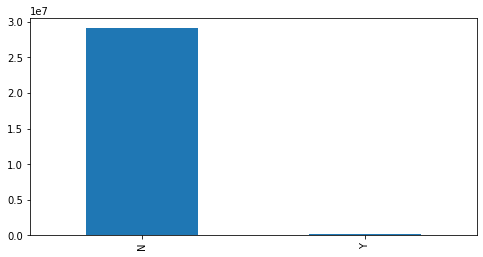

In [38]:
cat_features['store_and_fwd_flag'].value_counts().plot(kind='bar', figsize=(8,4))

- **PULocationID** and **DOLocationID**
    - They encode the location where the meter was engaged and disengaged. I also will skip using these columns because I think this information will be encoded in both the distance of the trip and the fare amount.

- **payment_type**
    - Here I will take only the payments made by card. Since we are interesting in predicting the tip amount in the rides, we won't cover situations like disputes or rides with no charges. Also, in the case of payments done with cash, as indicated in the dictionary, these **don't include the tip** so we can't use it to predict it.

### Date Features

In [39]:
date_features.describe(datetime_is_numeric=True)

,tpep_pickup_datetime,tpep_dropoff_datetime
count,29237237,29237237
mean,2017-07-02 02:51:06.465801472,2017-07-02 03:08:01.657239808
min,2001-01-01 00:04:13,2001-01-01 00:04:51
25%,2017-03-23 06:51:01,2017-03-23 07:03:01
50%,2017-06-14 07:50:54,2017-06-14 08:04:34
75%,2017-11-07 05:26:07,2017-11-07 05:44:52
max,2041-11-15 02:57:16,2041-11-15 03:12:19


By looking at the description of the *date features* we notice that we have information that is clearly wrong, for example having dates from 2041 or from 2001. We will select only records where months are March, June and November and year 2017

In [40]:
data_clean = data_clean[(data_clean['tpep_pickup_datetime'].dt.month.isin([3, 6, 11])) & 
                        (data_clean['tpep_pickup_datetime'].dt.year == 2017)]

Now, we will create a new variable to encode the information in these two columns. I will create a ride_total_time variable which will be the time elapsed between the two dates in minutes.

In [41]:
data_clean['trip_total_time'] = (data_clean['tpep_dropoff_datetime'] - data_clean['tpep_pickup_datetime']).astype('timedelta64[m]')

After creating this new variable, I will print its description. There we find that there are negative ride times. This is because the disengagement date is happening before engagement date, which is not correct. We could revert these dates to solve the problem but since I'm not sure they are correct, I prefer to just delete these records. Also I will delete records with ride_total_time equal to 0, because to me, these might be errors.

In [42]:
data_clean['trip_total_time'].describe()

count    2.651254e+07
mean     1.405103e+01
std      1.571844e+02
min     -6.000000e+01
25%      6.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      7.577710e+05
Name: trip_total_time, dtype: float64

In [43]:
data_clean = data_clean[data_clean['trip_total_time'] > 0]

Finally I will also delete outliers by using the IQR method, since it's possible that really long times are errors.

In [44]:
data_clean = delete_outliers(data_clean, 'trip_total_time')

In [45]:
data_clean.shape

(26353944, 17)

In [46]:
data_clean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,trip_total_time
1,1,2017-03-01 00:25:01,2017-03-01 00:31:36,1,1.4,1,N,239,262,1,7.5,0.5,0.5,1.75,0.0,0.3,6.0
10,1,2017-03-01 00:40:20,2017-03-01 00:49:02,1,1.9,1,N,95,28,1,8.5,0.5,0.5,1.96,0.0,0.3,8.0
11,1,2017-03-01 00:34:00,2017-03-01 01:02:27,1,6.9,1,N,48,223,1,25.0,0.5,0.5,5.25,0.0,0.3,28.0
12,1,2017-03-01 00:25:51,2017-03-01 00:28:14,1,0.3,1,N,90,68,2,3.5,0.5,0.5,0.00,0.0,0.3,2.0
13,1,2017-03-01 00:17:46,2017-03-01 00:32:58,1,4.2,1,N,142,79,1,15.0,0.5,0.5,2.20,0.0,0.3,15.0


Now I will like to see some plots from the data. In the first place, let's see a correlation plot to see which features are correlated.

In [47]:
corr = data_clean.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.9/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.9/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,trip_total_time
passenger_count,1.000000,0.010767,0.008600,0.002901,nan,-0.008848,nan,-0.000000,0.008580
trip_distance,0.010767,1.000000,0.910729,0.045737,nan,0.432906,nan,-0.000000,0.715502
fare_amount,0.008600,0.910729,1.000000,0.012115,nan,0.470214,nan,-0.000000,0.932920
extra,0.002901,0.045737,0.012115,1.000000,nan,0.053372,nan,0.000000,-0.006521
mta_tax,nan,nan,nan,nan,nan,nan,nan,nan,nan
tip_amount,-0.008848,0.432906,0.470214,0.053372,nan,1.000000,nan,0.000000,0.436603
tolls_amount,nan,nan,nan,nan,nan,nan,nan,nan,nan
improvement_surcharge,-0.000000,-0.000000,-0.000000,0.000000,nan,0.000000,nan,1.000000,0.000000
trip_total_time,0.008580,0.715502,0.932920,-0.006521,nan,0.436603,nan,0.000000,1.000000


As we can see in the plot, the tip as a fairly high correlation with the **trip distance**, the **the fare amount** and the feature we created, the **trip_total_time**. That means that our variable will be helpful when predicting the tip amount.

Now I will like to see if the tip amount depends on other categorical variables by looking at boxplots for them

<AxesSubplot:title={'center':'tip_amount'}, xlabel='[VendorID]'>

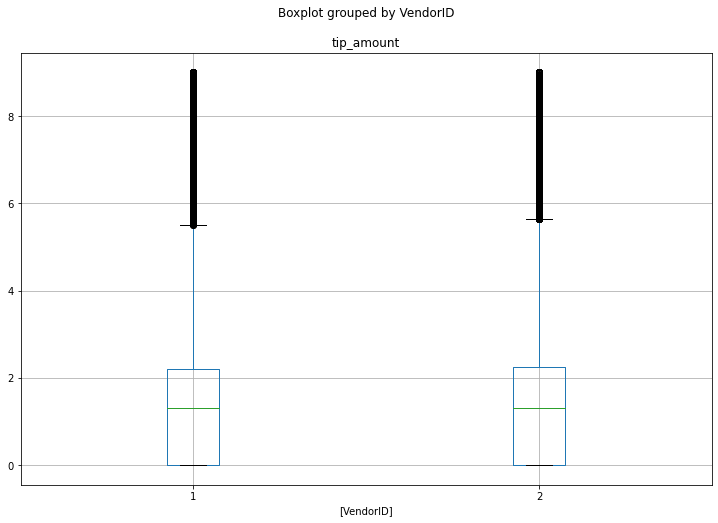

In [48]:
data_clean[['VendorID', 'tip_amount']].boxplot(by='VendorID', figsize=(12, 8))

<AxesSubplot:title={'center':'tip_amount'}, xlabel='[passenger_count]'>

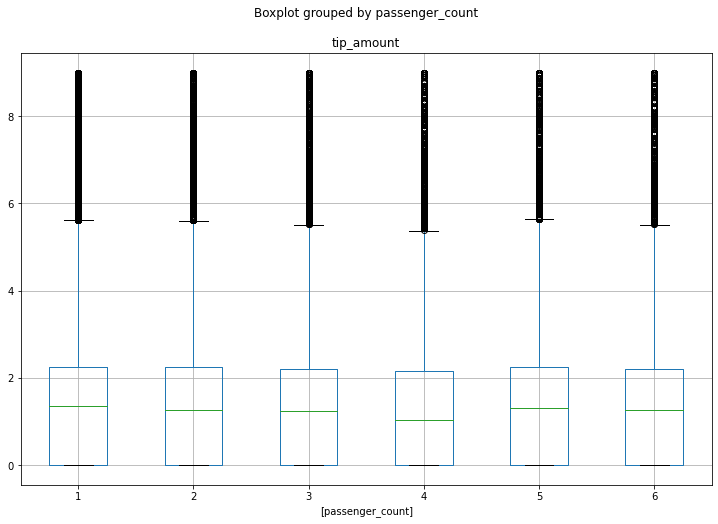

In [49]:
data_clean[['passenger_count', 'tip_amount']].boxplot(by='passenger_count', figsize=(12, 8))

<AxesSubplot:title={'center':'tip_amount'}, xlabel='[RatecodeID]'>

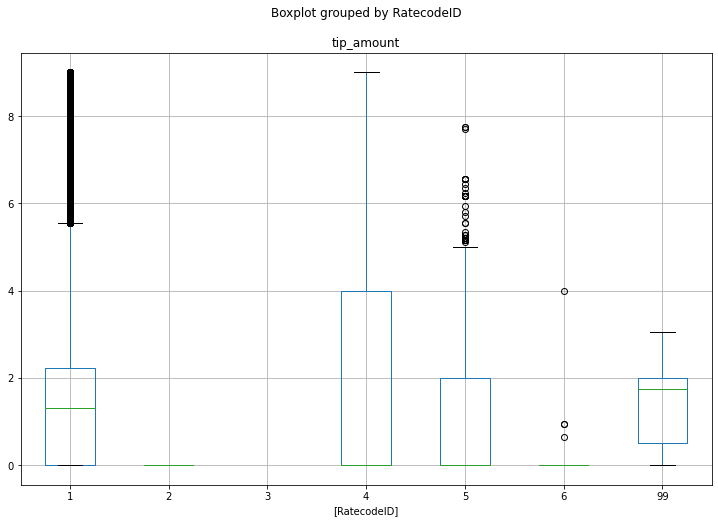

In [50]:
data_clean[['RatecodeID', 'tip_amount']].boxplot(by='RatecodeID', figsize=(12, 8))

<AxesSubplot:title={'center':'tip_amount'}, xlabel='[store_and_fwd_flag]'>

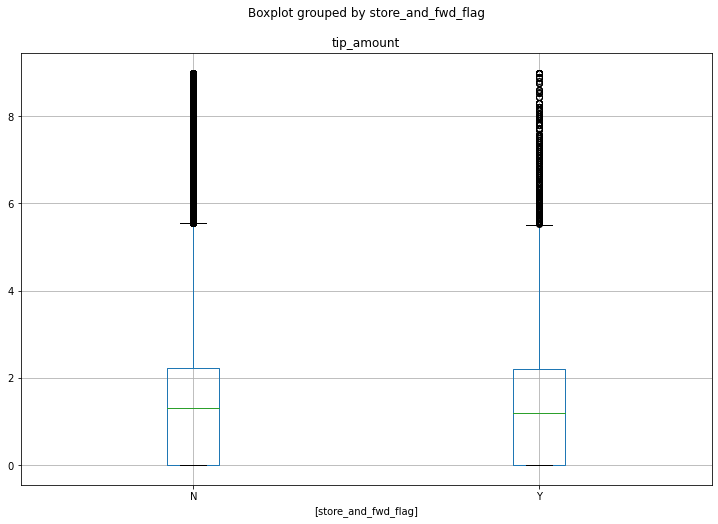

In [51]:
data_clean[['store_and_fwd_flag', 'tip_amount']].boxplot(by='store_and_fwd_flag', figsize=(12, 8))

<AxesSubplot:title={'center':'tip_amount'}, xlabel='[payment_type]'>

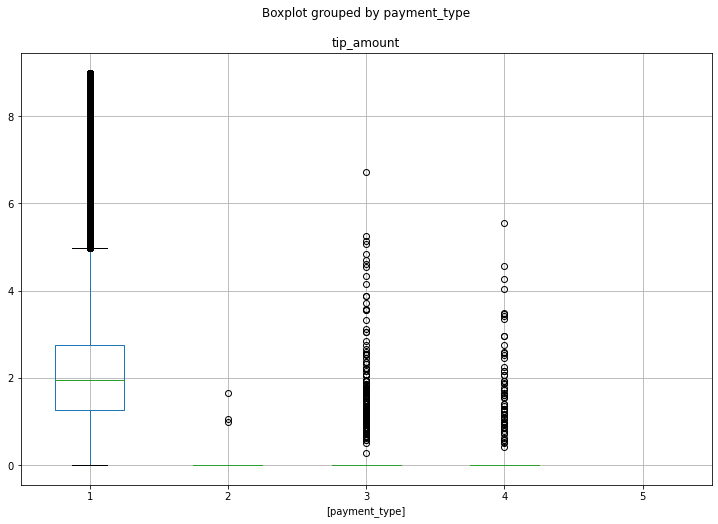

In [52]:
data_clean[['payment_type', 'tip_amount']].boxplot(by='payment_type', figsize=(12, 8))

As we can see in the previous plots, the tip_amount only have differences in two variables:
- **RatecodeID**: There are differences, although in most of the cases, the average tip amount is zero, except in the RatecodeID 1, which means Standard Rate, and 99, which is not defined in the dictionary. I will delete this feature, since it may be noisy.
- **payment_type**: In this case, as we can see, the tips are basically 0 when the payment type is different than 1. I will keep only the rows with this payment type.

In [53]:
data_clean = data_clean[data_clean['payment_type'] == 1]

## Model building

First before building our model, let's transform the columns we will use as indicated before. 

**The data will be split in Training and Test sets**. The Test set will be a 20% of the total amount of data. The train set will be used for training and the test to evaluate the model in data that haven't been seen before.

Our model will need numeric features to be able to train properly, so we will delete the date columns, the don't needed categorical columns, and the needed ones will be encoded as One Hot Vectors. I will also Normalize and Scale the features. This will help the training process and will avoid that fetures which values in bigger scales take importance and "hide" others with smaller values.

**The selected model will be an XGBoost model**, since it has been proved multiple times to work well in problems with tabular data as the one we have here. I will use a Randomized Grid Search with Cross Validation to optimize the hiper parameters of the model. I will use small number of K for the CrossValidation, since the dataset is hughe and will take time. I will also execute through 5 iterations, which means it will take 5 combination of values from the distributions given for each hyperparameter. Of course, we could lead to better results by trying more combinations, but for this use case, I think this will be enough.

Finally, **to evaluate the quality of the model, the RMSE will be used**. I will use this measure because it's easy to explain and interprete, since the results are in the same unit as the target feature, and because it penalizes bigger errors over smaller errors. 

In [54]:
data_model = data_clean.drop(columns=['tpep_pickup_datetime', 
                                      'tpep_dropoff_datetime',
                                      'PULocationID', 
                                      'DOLocationID',
                                      'payment_type',
                                      'VendorID',
                                      'RatecodeID'])

In [55]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data_model.loc[:, data_model.columns != 'tip_amount'], data_model['tip_amount'], test_size=0.20)

In [57]:
X_train.head()

,passenger_count,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,trip_total_time
1946129,1,2.40,N,10.5,0.5,0.5,0.0,0.3,11.0
5416415,1,1.10,N,6.0,0.0,0.5,0.0,0.3,5.0
5200689,1,1.69,N,13.0,0.0,0.5,0.0,0.3,20.0
370899,1,0.90,N,7.0,0.0,0.5,0.0,0.3,7.0
4278562,1,5.20,N,17.0,0.5,0.5,0.0,0.3,15.0


In [58]:
num_features = X_train.select_dtypes('number')

In [59]:
cat_features = X_train.select_dtypes('category')

In [60]:
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])


numerical_pipeline = Pipeline(steps=[
    ('normalizer', Normalizer()),
    ('scaler', MinMaxScaler())
])


In [61]:
full_pipeline = ColumnTransformer(transformers=[
    ('numbers', numerical_pipeline, num_features.columns.values),
    ('categories', categorical_pipeline, cat_features.columns.values),
])

In [62]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [63]:
xgb_pipeline = Pipeline(steps=[
    ('processor', full_pipeline),
    ('xgb_model', xgb_model)
])

In [64]:
param_dict = {
    'xgb_model__colsample_bytree': [0.2, 0.3, 0.5],
    'xgb_model__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model__alpha': [0, 1, 10],
    'xgb_model__max_depth': [5, 10],
    'xgb_model__n_estimators': [100, 500, 1000]
}

In [65]:
search = RandomizedSearchCV(xgb_pipeline, 
                            param_dict, 
                            cv=3,
                            n_iter=5,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=4)

In [66]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('processor',
                                              ColumnTransformer(transformers=[('numbers',
                                                                               Pipeline(steps=[('normalizer',
                                                                                                Normalizer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               array(['passenger_count', 'trip_distance', 'fare_amount', 'extra',
       'mta_tax', 'tolls_amount', 'improvement_surcharge',
       'trip_total_time'], dtype=object)),
                                                                              ('categories',
                                                                               Pipeline(ste...
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=None,
                                                           reg_alpha=None,
                                                           reg_lambda=None, ...))]),
                   n_iter=5, n_jobs=4,
                   param_distributions={'xgb_model__alpha': [0, 1, 10],
                                        'xgb_model__colsample_bytree': [0.2,
                                                                        0.3,
                                                                        0.5],
                                        'xgb_model__learning_rate': [0.1, 0.01,
                                                                     0.001],
                                        'xgb_model__max_depth': [5, 10],
                                        'xgb_model__n_estimators': [100, 500,
                                                                    1000]},
                   scoring='neg_root_mean_squared_error')

I will save the grid search object so we don't need to train the model again.

In [67]:
import joblib

In [68]:
joblib.dump(search, 'grid_search_model.pkl')

['grid_search_model.pkl']

Finally, let's make predictions on the Test set by using the best model found by the Randomized Grid Search. Then we will evaluate using the RMSE to see the performance of our model.

In [69]:
preds = search.best_estimator_.predict(X_test)

In [70]:
mean_squared_error(y_test, preds, squared=False)

0.8678978127017343